# Shiv Pratap Singh 200968038

### 1. Use the German credit rating dataset “German Credit Data.csv” , Decision tree classifier to predict good or bad credit. Use “sklearn.model_selection” and GridSearchCV to search the hyperparameter values and report the most optimal one. Configure the grid search to search for optimal parameters:
1. Splitting criteria: gini or entropy.
2. Maximum depth of decision tree ranging from 2 to 10.
3. The searching of optimal parameter will be validated using 10-fold cross validation and the most optimal parameter will be chosen based on ROC-AUC score.

In [58]:
import pandas as pd
df = pd.read_csv('German Credit Data.csv')

In [59]:
df.head()

,checkin_acc,duration,credit_history,amount,savings_acc,present_emp_since,inst_rate,personal_status,residing_since,age,inst_plans,num_credits,job,status
0,A11,6,A34,1169,A65,A75,4,A93,4,67,A143,2,A173,0
1,A12,48,A32,5951,A61,A73,2,A92,2,22,A143,1,A173,1
2,A14,12,A34,2096,A61,A74,2,A93,3,49,A143,1,A172,0
3,A11,42,A32,7882,A61,A74,2,A93,4,45,A143,1,A173,0
4,A11,24,A33,4870,A61,A73,3,A93,4,53,A143,2,A173,1


There are two classes, 1 for good customers and 2 for bad customers. Good customers are the default or negative class, whereas bad customers are the exception or positive class.

Seeing all the categorical variable counts

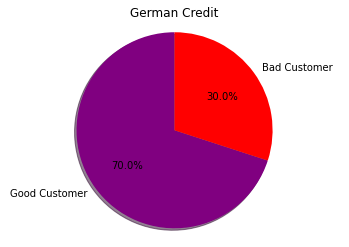

In [60]:
import matplotlib.pyplot as plt
label = ['Good Customer','Bad Customer']
plt.pie(df['status'].value_counts(), labels=label, autopct='%1.1f%%', explode=[0,0], shadow=True, startangle=90,colors=['purple','red'])
plt.title('German Credit')
plt.axis('equal')
plt.show()

We can see that the dataset is unbalanced

In [61]:
df.isnull().sum()

checkin_acc          0
duration             0
credit_history       0
amount               0
savings_acc          0
present_emp_since    0
inst_rate            0
personal_status      0
residing_since       0
age                  0
inst_plans           0
num_credits          0
job                  0
status               0
dtype: int64

No missing values

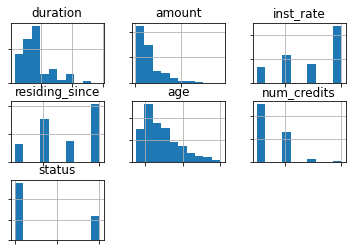

In [62]:
num_ix = df.select_dtypes(include=['int64', 'float64']).columns
# select a subset of the dataframe with the chosen columns
subset = df[num_ix]
# create a histogram plot of each numeric variable
ax = subset.hist()

for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])
# show the plot
plt.show()

We can see numerical attributes have different distributions, we'll have to standardize them

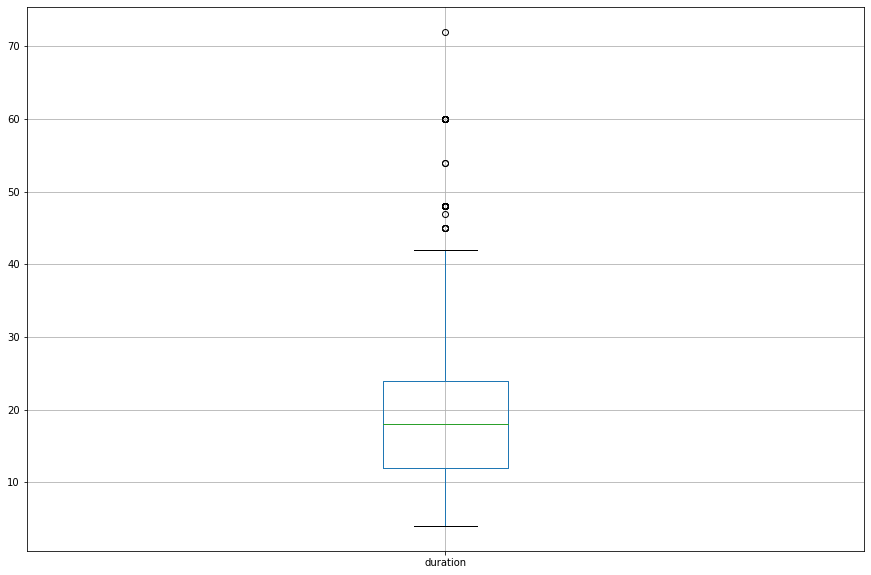

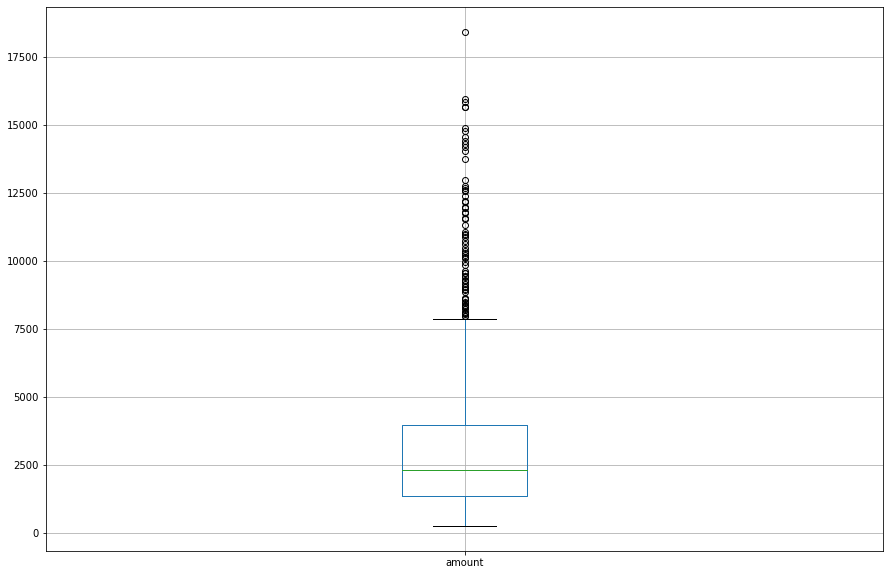

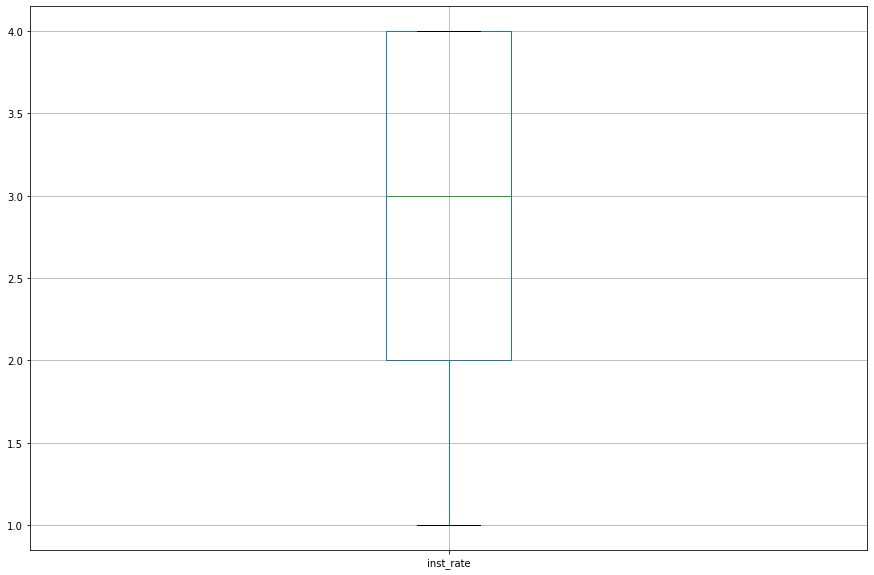

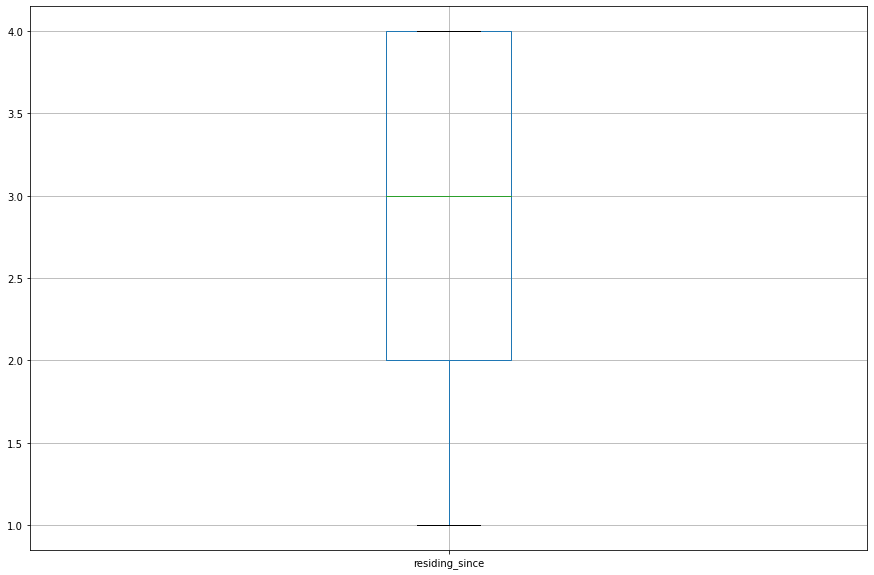

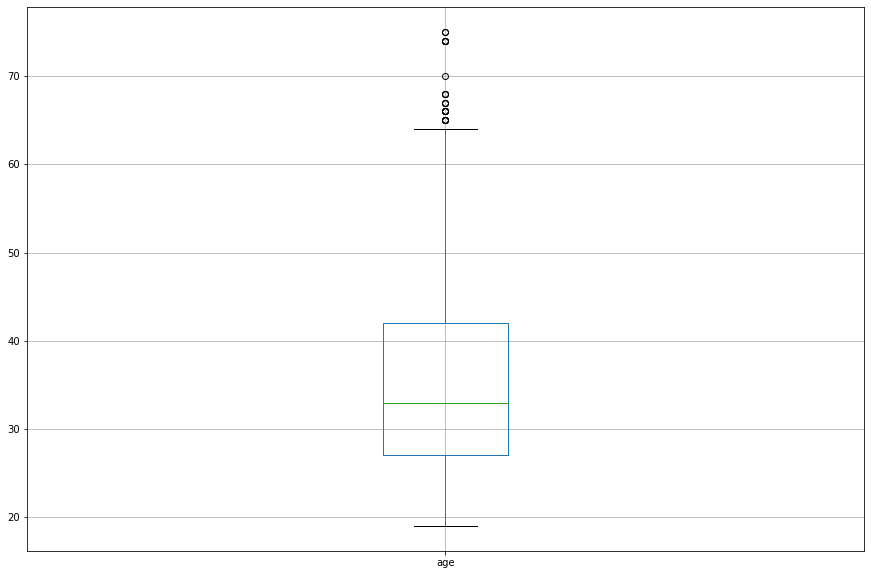

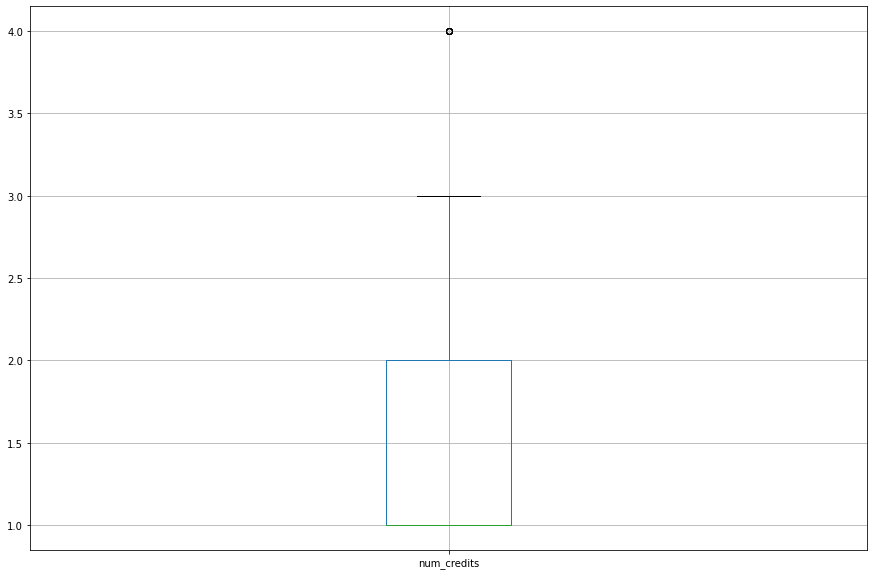

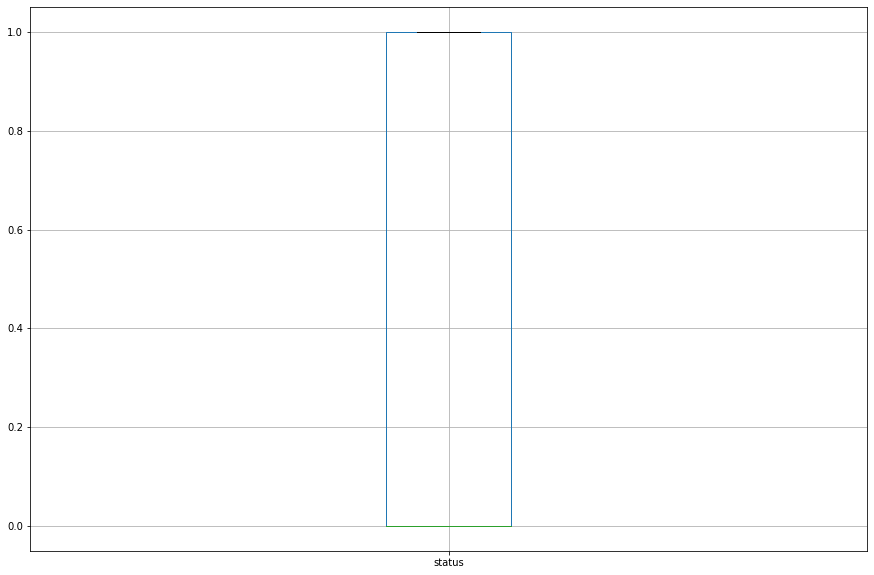

In [7]:
import matplotlib.pyplot as plt

for column in num_ix:
    plt.figure(figsize=(15,10))
    df.boxplot([column])

Massive amounts of Outliers detected. But since Decision Trees are robust to outliers and distributions of numerical attributes we dont have to treat these issues

In [29]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split

from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn import metrics

import warnings

warnings.filterwarnings('ignore')

In [9]:
cat_ix = df.select_dtypes(include=['object']).columns
df_fin = pd.get_dummies(df,columns = cat_ix,drop_first=True)

In [10]:
X = df_fin.drop('status',axis=1)
y= df_fin['status']

In [31]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=45)

We train a model without doing any hyperparameter tuning, just to compare the results after grid search cross validation

In [32]:
base_model = DecisionTreeClassifier(random_state=42)
scores = cross_val_score(base_model, X = x_train , y = y_train , cv = 10, )
scores.mean()

0.68625

This is the score we get without grid search over hyperparameter space

In [34]:
clf = GridSearchCV(DecisionTreeClassifier(random_state=42),param_grid={'criterion' : ['gini','entropy'],'splitter' : ['best','random'],'max_depth' : range(1,20),'min_samples_split' : range(2,10),'min_samples_leaf' : range(1,10)},cv=10,scoring='roc_auc')

In [35]:
clf.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 20),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10),
                         'splitter': ['best', 'random']},
             scoring='roc_auc')

Best Parameters we got. We'll also fix the random state in the dictionary and pass it in its entirety in DecisionTreeClassifier

In [36]:
best_params = clf.best_params_
print(best_params)

{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 9, 'min_samples_split': 2, 'splitter': 'random'}


In [37]:
best_params['random_state'] = 42

In [39]:
model = DecisionTreeClassifier(**best_params).fit(x_train,y_train)

In [40]:
model.score(x_test,y_test)

0.71

In [41]:
model.score(x_train,y_train)

0.79125

### 2. Visualize the tree using graphviz software.

In [42]:
!pip install graphviz

You should consider upgrading via the 'C:\Users\spssh\anaconda3\python.exe -m pip install --upgrade pip' command.


In [65]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

In [66]:
import graphviz

Making the dot file using Graphviz software

In [69]:
from sklearn import tree
dot_data = tree.export_graphviz(model, 
                                feature_names=x_train.columns,  
                                class_names=['Defaulter','Not Defaulter'],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                out_file=None)

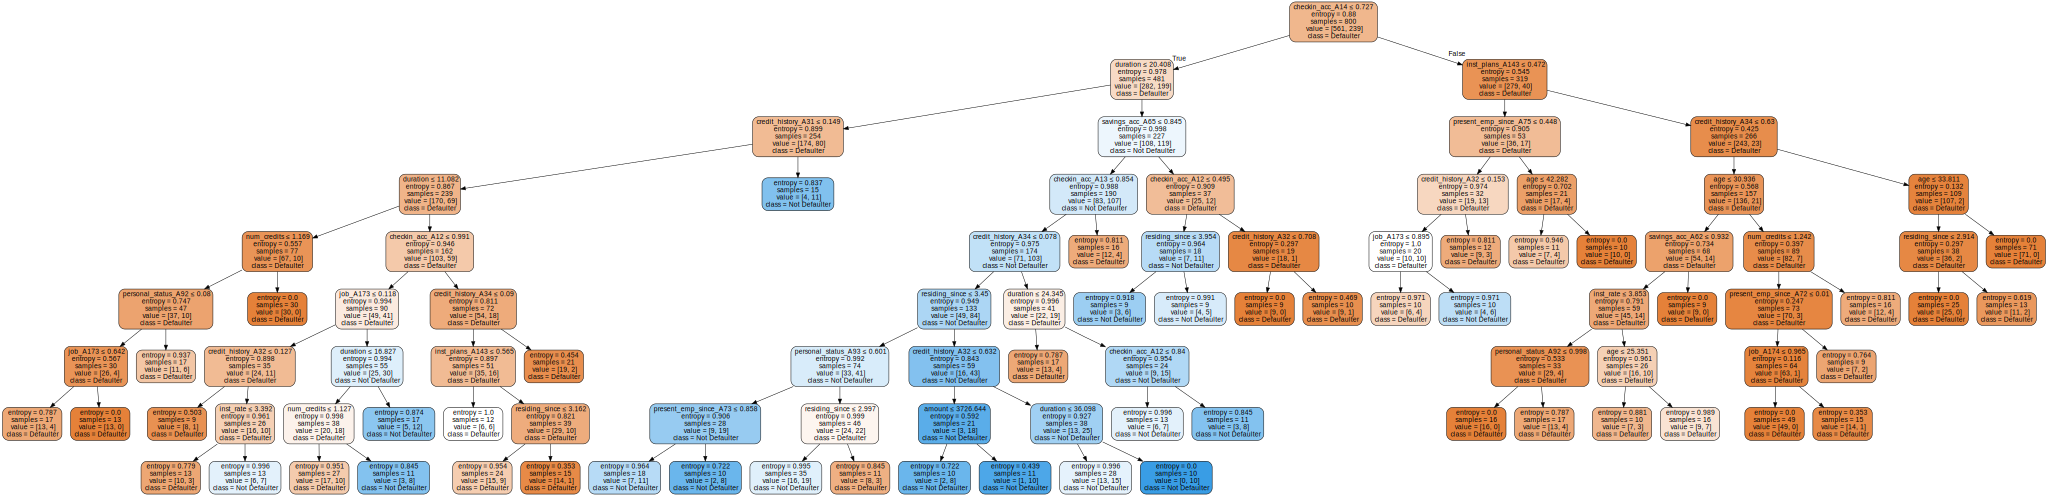

In [70]:
graph = graphviz.Source(dot_data)
graph

### 3. Display the text representation of the rules learnt.

In [80]:
relevant_col = list(x_train.columns)

In [81]:
text_representation = tree.export_text(model , feature_names= relevant_col)
print(text_representation)

|--- checkin_acc_A14 <= 0.73
|   |--- duration <= 20.41
|   |   |--- credit_history_A31 <= 0.15
|   |   |   |--- duration <= 11.08
|   |   |   |   |--- num_credits <= 1.17
|   |   |   |   |   |--- personal_status_A92 <= 0.08
|   |   |   |   |   |   |--- job_A173 <= 0.64
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- job_A173 >  0.64
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- personal_status_A92 >  0.08
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- num_credits >  1.17
|   |   |   |   |   |--- class: 0
|   |   |   |--- duration >  11.08
|   |   |   |   |--- checkin_acc_A12 <= 0.99
|   |   |   |   |   |--- job_A173 <= 0.12
|   |   |   |   |   |   |--- credit_history_A32 <= 0.13
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- credit_history_A32 >  0.13
|   |   |   |   |   |   |   |--- inst_rate <= 3.39
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- inst_rate >  3.39
|   |   |

# EX2

### Download fuel consumption dataset "FuelConsumption.csv", which contains modelspecific fuel consumption ratings and estimated carbon dioxide emissions. 


### 1. Select the features 'ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_COMB', 'CO2EMISSIONS' to use for building the model. Plot Emission values with respect to Engine size.

In [88]:
df2 = pd.read_csv('FuelConsumption.csv')
df2

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,2014,VOLVO,XC60 AWD,SUV - SMALL,3.0,6,AS6,X,13.4,9.8,11.8,24,271
1063,2014,VOLVO,XC60 AWD,SUV - SMALL,3.2,6,AS6,X,13.2,9.5,11.5,25,264
1064,2014,VOLVO,XC70 AWD,SUV - SMALL,3.0,6,AS6,X,13.4,9.8,11.8,24,271
1065,2014,VOLVO,XC70 AWD,SUV - SMALL,3.2,6,AS6,X,12.9,9.3,11.3,25,260


In [92]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MODELYEAR                 1067 non-null   int64  
 1   MAKE                      1067 non-null   object 
 2   MODEL                     1067 non-null   object 
 3   VEHICLECLASS              1067 non-null   object 
 4   ENGINESIZE                1067 non-null   float64
 5   CYLINDERS                 1067 non-null   int64  
 6   TRANSMISSION              1067 non-null   object 
 7   FUELTYPE                  1067 non-null   object 
 8   FUELCONSUMPTION_CITY      1067 non-null   float64
 9   FUELCONSUMPTION_HWY       1067 non-null   float64
 10  FUELCONSUMPTION_COMB      1067 non-null   float64
 11  FUELCONSUMPTION_COMB_MPG  1067 non-null   int64  
 12  CO2EMISSIONS              1067 non-null   int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 108.5+ KB


In [93]:
df2.isna().sum()

MODELYEAR                   0
MAKE                        0
MODEL                       0
VEHICLECLASS                0
ENGINESIZE                  0
CYLINDERS                   0
TRANSMISSION                0
FUELTYPE                    0
FUELCONSUMPTION_CITY        0
FUELCONSUMPTION_HWY         0
FUELCONSUMPTION_COMB        0
FUELCONSUMPTION_COMB_MPG    0
CO2EMISSIONS                0
dtype: int64

No Missing values

In [94]:
X = df2[['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_COMB']]
y = df2['CO2EMISSIONS']

<AxesSubplot:>

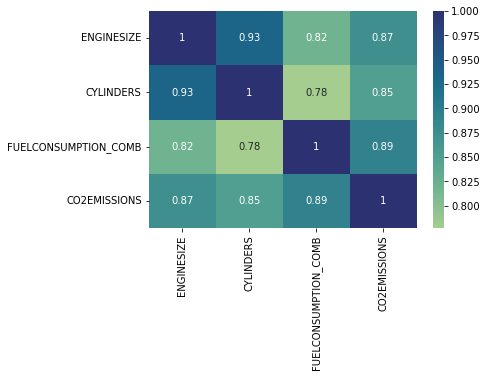

In [100]:
import seaborn as sns
sns.heatmap(df2[['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_COMB','CO2EMISSIONS']].corr(),annot=True,cmap = 'crest')

High Multicollinearity is observed however, multicollinearity doesnt affect our predicting power also the question has asked us to stick to given set of features therefore we continue.

Plot EngineSize against CO2Emissions

<AxesSubplot:xlabel='ENGINESIZE'>

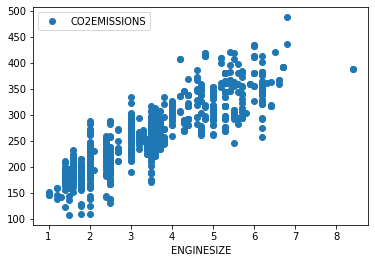

In [90]:
X.plot(x = 'ENGINESIZE', y = 'CO2EMISSIONS',style = 'o')

### 2. Split the data into training and test sets (70:30) to create a model using training set, evaluate the model using test set, and use model to predict unknown value.

In [95]:
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 90)

Before moving onto polynomial regression lets just try a multiple linear regression model

In [106]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [107]:
linear_model = Pipeline([
        ('Scaler',StandardScaler()),
        ('PolynomialFeatures',PolynomialFeatures(degree=1)),
        ('Regression',LinearRegression())
    ])

In [108]:
linear_model.fit(X_train,y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('PolynomialFeatures', PolynomialFeatures(degree=1)),
                ('Regression', LinearRegression())])

In [109]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_pred = linear_model.predict(X_test)

In [110]:
print('The Model Metrics - ')
print(f'MSE of Model = {mean_squared_error(y_test,y_pred)}')
print(f'RMSE of Model = {mean_squared_error(y_test,y_pred,squared = False)}')
print(f'R2 score = {r2_score(y_test,y_pred)}')

The Model Metrics - 
MSE of Model = 531.6582412411412
RMSE of Model = 23.057715438463134
R2 score = 0.8482111512891156


The metrics are decent, R2 = 0.8482 is a good model

### 2. Try to use a polynomial regression with the dataset of cubic degree and verify the accuracy by calculating Mean absolute error, Residual sum of squares, R2-score.

In [112]:
model_polynomial = Pipeline([
    ('Scaler',StandardScaler()),
    ('PolynomialFeatures',PolynomialFeatures(degree=3)),
    ('Regression',LinearRegression())
])

In [113]:
model_polynomial.fit(X_train,y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('PolynomialFeatures', PolynomialFeatures(degree=3)),
                ('Regression', LinearRegression())])

In [114]:
y_pred = model_polynomial.predict(X_test)

In [115]:
print('The Model Metrics - ')
print(f'MSE of Model = {mean_squared_error(y_test,y_pred)}')
print(f'RMSE of Model = {mean_squared_error(y_test,y_pred,squared = False)}')
print(f'R2 score = {r2_score(y_test,y_pred)}')

The Model Metrics - 
MSE of Model = 345.6555242767729
RMSE of Model = 18.591813367091788
R2 score = 0.9013150742137532


These are the test metrics, the explainability power of model has clearly increased. All metrics have improved considerably, ideally we'll proceed with experimentation and try to find a better degree of polynomial expression.